### Dataset

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm

%matplotlib inline

df = pd.read_csv('../datasets/course.csv')

categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
numerical_columns = [col for col in df.columns if df[col].dtype != 'object' and col != 'converted']

df[categorical_columns] = df[categorical_columns].fillna('NA')
df[numerical_columns] = df[numerical_columns].fillna(0)


### Split the dataset into train, validation, and test sets

In [33]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)  
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

del df_train['converted']
del df_val['converted']
del df_test['converted']

### One hot encoding

In [34]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)


### Train the model using Logistic Regression

In [35]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_val)[:,1] # Probability of positive class [all rows, column 1]
y_pred = model.predict(X_val) # Returns class labels
y_pred_prob[:5],y_pred[:5]


(array([0.57539503, 0.47060768, 0.61901235, 0.6143892 , 0.6174103 ]),
 array([1, 0, 1, 1, 1]))

### Accuracy

In [36]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred_prob >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.584
0.05 0.584
0.10 0.584
0.15 0.584
0.20 0.584
0.25 0.584
0.30 0.594
0.35 0.601
0.40 0.642
0.45 0.679
0.50 0.700
0.55 0.747
0.60 0.747
0.65 0.734
0.70 0.693
0.75 0.655
0.80 0.614
0.85 0.567
0.90 0.495
0.95 0.433
1.00 0.416


### Confusion matrix

In [37]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
t = 0.55
predict_positive = (y_pred_prob >= t)
predict_negative = (y_pred_prob < t)
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix


array([[ 60,  62],
       [ 12, 159]])

### Precision  and Recall
Precision = TP / (TP + FP)  
Recall    = TP / (TP + FN)

In [38]:
p = tp / (tp + fp)
r = tp / (tp + fn)
p, r    

(np.float64(0.7194570135746606), np.float64(0.9298245614035088))

### ROC and AUC
True Postive Rate (TPR)   = Sensitivity = Recall  = TP / (TP + FN), we need to maximize this metric.    
False Positive Rate (FPR) = 1 - Specificity = FP / (FP +TN)  we need to minimize this metric.   
ROC (Receiver Operator Characteristic) curve considers TPR and FPR under all the possible thresholds and makes it easier to identify best threshold.   
AUC (Area Under Curve) makes it easier to compare one ROC curve to another.


In [39]:
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tpr, fpr

(np.float64(0.9298245614035088), np.float64(0.5081967213114754))

In [40]:
# Manual method to plot metrics
scores = []
thresholds = np.linspace(0.0, 1.0, 101)
for t in thresholds:
    
    predict_positive = (y_pred_prob >= t)
    predict_negative = (y_pred_prob < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    precision = tp/(tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) 
    fpr = fp / (fp + tn) 
    
    scores.append((t, precision,recall,fpr))
   
columns = ['threshold', 'precision', 'recall/tpr','fpr']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores


,threshold,precision,recall/tpr,fpr
0,0.00,0.583618,1.000000,1.0
1,0.01,0.583618,1.000000,1.0
2,0.02,0.583618,1.000000,1.0
3,0.03,0.583618,1.000000,1.0
4,0.04,0.583618,1.000000,1.0
...,...,...,...,...
96,0.96,1.000000,0.017544,0.0
97,0.97,1.000000,0.005848,0.0
98,0.98,0.000000,0.000000,0.0
99,0.99,0.000000,0.000000,0.0


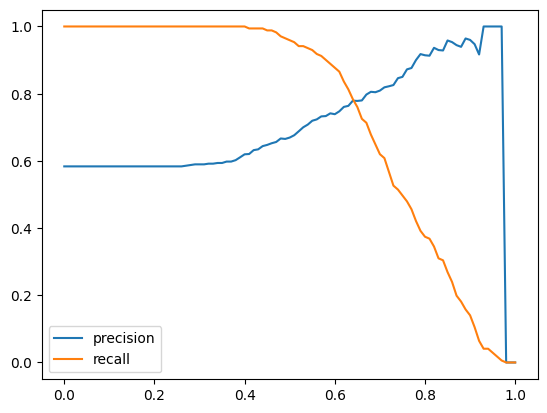

In [41]:
#  Plot precision-recall curve

plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall/tpr'], label='recall')
plt.legend()


<Axes: xlabel='fpr'>

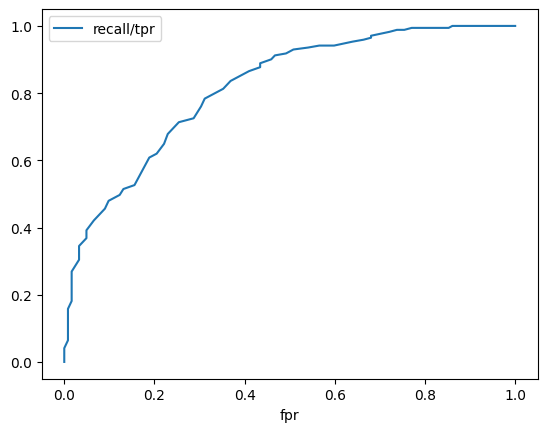

In [42]:
# Plot ROC curve
df_scores.plot(x='fpr', y='recall/tpr')

Text(0.5, 1.0, 'ROC curve')

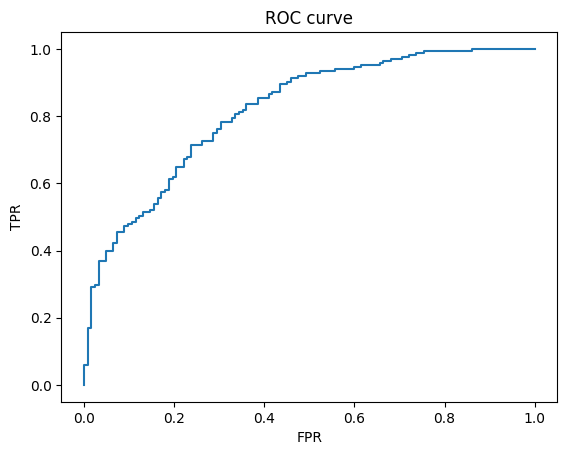

In [43]:
# Using sklearn to plot ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlabel('FPR')   
plt.ylabel('TPR')
plt.title('ROC curve')  


In [44]:
"""
For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.
"""

for col in numerical_columns:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col]) # negative correlation becomes positive.
    print('%s: %f' % (col, auc))

number_of_courses_viewed: 0.763568
annual_income: 0.551958
interaction_count: 0.738270
lead_score: 0.614499


In [45]:
roc_auc_score(y_val, y_pred_prob)

0.8171316268814112

### F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2[(P*R)/(P+R)]

Where 
P is precision and R is recall.

In [46]:
thresholds = np.arange(0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred = (y_pred_prob >= t).astype(int)
    f1_scores.append((t, f1_score(y_val, y_pred)))

columns = ['threshold', 'f1_score']
df_f1_scores = pd.DataFrame(f1_scores, columns=columns)
df_f1_scores


,threshold,f1_score
0,0.00,0.737069
1,0.01,0.737069
2,0.02,0.737069
3,0.03,0.737069
4,0.04,0.737069
...,...,...
96,0.96,0.034483
97,0.97,0.011628
98,0.98,0.000000
99,0.99,0.000000


In [47]:
df_f1_scores.loc[df_f1_scores.f1_score.idxmax()]


threshold    0.5700
f1_score     0.8125
Name: 57, dtype: float64

### Cross Validation
Evaluating the same model on different subsets of data
Getting the average prediction and the spread within predictions

In [48]:
scaler = StandardScaler()
dv = DictVectorizer(sparse=False)

def train(df_train, y_train, dv, scaler, C=1.0):
    df_train = df_train.copy()
    if 'converted' in df_train.columns:
        df_train = df_train.drop('converted', axis=1)
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    X_train = dv.fit_transform(dicts)    
    X_train_scaled = scaler.fit_transform(X_train)
      
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    return model

In [49]:
model = train(df_train, y_train, dv,scaler,C=0.001)

In [50]:
def predict(df, dv, scaler, model):
    df = df.copy()
    if 'converted' in df.columns:
        df = df.drop('converted', axis=1)
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    X_val_scaled = scaler.transform(X)  
    y_pred_prob = model.predict_proba(X_val_scaled)[:, 1]
 
    return y_pred_prob

In [51]:
y_pred_prob = predict(df_val, dv, scaler, model)

In [52]:
kfold = KFold(n_splits = 5, shuffle = True, random_state= 1)
scores  = []
for train_idx, val_idx in kfold.split(df_full_train):
    
    df_train = df_full_train.iloc[train_idx].copy()
    df_val = df_full_train.iloc[val_idx].copy()
    
    y_train = df_train.converted.values
    y_val = df_val.converted.values
    
    model = train(df_train, y_train, dv, scaler, C=1.0)
    y_pred = predict(df_val, dv, scaler, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

    

print('AUC scores for each fold:', scores)
print('Mean AUC:', np.mean(scores))
print('Standard deviation of AUC:', np.std(scores))


AUC scores for each fold: [0.9212387404153949, 0.9318164047228086, 0.9061693642974431, 0.9103362391033624, 0.9307382758086984]
Mean AUC: 0.9200598048695415
Standard deviation of AUC: 0.010403166260574156


In [54]:
for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        
        df_train = df_full_train.iloc[train_idx].copy()
        df_val = df_full_train.iloc[val_idx].copy()

        y_train = df_train.converted.values
        y_val = df_val.converted.values
       
        model = train(df_train, y_train, dv, scaler, C=C)
        y_pred = predict(df_val, dv, scaler, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s => AUC Mean : %.3f, AUC Standard-Deviaton: %.5f' % (C, np.mean(scores), np.std(scores)))


  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.66it/s]

C=1e-06 => AUC Mean : 0.907, AUC Standard-Deviaton: 0.00872
C=0.001 => AUC Mean : 0.911, AUC Standard-Deviaton: 0.00869


100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

C=1 => AUC Mean : 0.920, AUC Standard-Deviaton: 0.01040


In [55]:
model = train(df_full_train, df_full_train.converted.values, dv, scaler, C=1.0)
y_pred = predict(df_test, dv, scaler, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.9228410832907511